In [0]:
# Import
import pandas as pd
import nltk
import numpy as np

from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/fake_or_real_news.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Xiang Li 

#### A first look at the dataset
random key            title       te

In [0]:
import numpy as np

df.head()

,Unnamed: 0,title,text,label,title_vectors
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,[ 1.1533764e-02 4.2144405e-03 1.9692603e-02 ...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,[ 0.11267698 0.02518966 -0.00212591 0.021095...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,[ 0.04253004 0.04300297 0.01848392 0.048672...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,[ 0.10801624 0.11583211 0.02874823 0.061732...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,[ 1.69016439e-02 7.13498285e-03 -7.81233795e-...


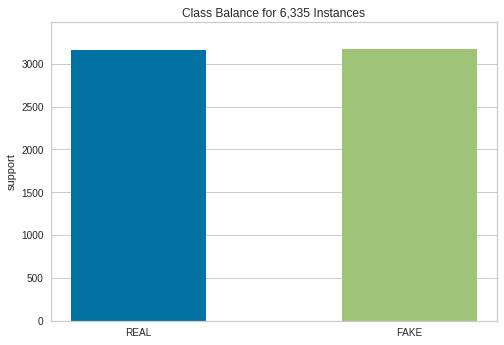

In [0]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=["REAL", "FAKE"])
visualizer.fit(df.label)
visualizer.poof()

In [0]:
df.groupby('label').size()

label
FAKE    3164
REAL    3171
dtype: int64

A balanced dataset !~

#### Tokenize

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
texts = df.text.values
titles = df.title.values

tokenizedText = [nltk.word_tokenize(text) for text in texts]
tokenizedTitle = [nltk.word_tokenize(title) for title in titles]

In [0]:
print(titles[0])
print(tokenizedTitle[0])

#### Remove Stopwords and punctuations, Lower-case

In [0]:
print(punctuation)

In [0]:
print(stopwords)

In [0]:
from string import punctuation
from itertools import chain
from nltk.corpus import stopwords

def cleanText(tokenizedList, stopwords, punctuation):
    newList = []
    for doc in tokenizedList:
        newList.append([token.lower() for token in doc if token.lower() not in chain(punctuation, stopwords)])
    return newList

punctuation+="’"

In [0]:
cleanedText = cleanText(tokenizedText, stopwords, punctuation)
cleanedTitle = cleanText(tokenizedTitle, stopwords, punctuation)

In [0]:
print(titles[28])
print(cleanedTitle[28])

#### Stem

In [0]:
from nltk.stem.porter import PorterStemmer  

stemmer = PorterStemmer()  
stemmedText = []
for index in range(len(cleanedText)):
    stemmedText.append([])
    for i in range(len(cleanedText[index])):
        stemmedText[index].append(stemmer.stem(cleanedText[index][i]) )
        
stemmedTitle = []
for index in range(len(cleanedTitle)):
    stemmedTitle.append([])
    for i in range(len(cleanedTitle[index])):
        stemmedTitle[index].append(stemmer.stem(cleanedTitle[index][i]) )

In [0]:
print(titles[22])
print(stemmedTitle[22])

![a](https://drive.google.com/open?id=1Af-HBQRC9LvLnJ13wErn3l0xGuDGWr6w)

#### Lemmatize

In [0]:
nltk.download('wordnet')

In [0]:
from nltk.stem.wordnet import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()  
lemmatizedText = []
for index in range(len(cleanedText)):
    lemmatizedText.append([])
    for i in range(len(cleanedText[index])):
        lemmatizedText[index].append(lemmatizer.lemmatize(cleanedText[index][i]) )
        
lemmatizedTitle = []
for index in range(len(cleanedTitle)):
    lemmatizedTitle.append([])
    for i in range(len(cleanedTitle[index])):
        lemmatizedTitle[index].append(lemmatizer.lemmatize(cleanedTitle[index][i]) )

# 2. Linchuan

## 2.1 EDA

word frequency

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stopwords = stopwords.words('english')

all_fake = df.loc[df['label'] == 'FAKE']
all_real = df.loc[df['label'] == "REAL"]

temp = pd.Series(np.concatenate([x.lower().split() for x in all_fake.text])).value_counts()

new = temp.drop(labels=stopwords, errors="ignore")
new = new.drop(labels=["–", ",", ".", "—", "would"], errors="ignore")
new[:25]

In [0]:
from nltk import ngrams
from collections import defaultdict
import operator
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from collections import Counter 

fake_twogram_dict = defaultdict()
real_twogram_dict = defaultdict()

myfilter = stopwords.words('english')
myfilter.extend([".", ",", "\"", "’", "“", ":", "?", "(", ")", "”", "''", "``"])

for each in all_fake.text:
  filtered_sentence = [w for w in word_tokenize(each) if not w in myfilter] 
  sentence = " ".join(filtered_sentence)
  twograms = ngrams(sentence.split(), 2)
  for grams in twograms:
    if grams in fake_twogram_dict:
      fake_twogram_dict[grams] += 1
    else:
      fake_twogram_dict[grams] = 1


for each in all_real.text:
  filtered_sentence = [w for w in word_tokenize(each) if not w in myfilter] 
  sentence = " ".join(filtered_sentence)
  twograms = ngrams(sentence.split(), 2)
  for grams in twograms:
    if grams in real_twogram_dict:
      real_twogram_dict[grams] += 1
    else:
      real_twogram_dict[grams] = 1



sorted_fake_twogram_list = sorted(fake_twogram_dict, key=fake_twogram_dict.get, reverse=True)[:30]
sorted_real_twogram_list = sorted(real_twogram_dict, key=real_twogram_dict.get, reverse=True)[:30]

fake_C = Counter(fake_twogram_dict)
real_C = Counter(real_twogram_dict)
print(fake_C.most_common(25))
print(real_C.most_common(25))

## 2.2 Creating Word embedding

In [0]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [0]:
joined_cleanedText = []
joined_cleanedTitle = []
joined_cleanedTitleAndText = []
seperator = " "
for each in cleanedText:
  joined_cleanedText.append(seperator.join(each))

for each in cleanedTitle:
  joined_cleanedTitle.append(seperator.join(each))

for i in range(0, len(cleanedTitle)):
  joined_cleanedTitleAndText.append(seperator.join(cleanedText[i]) + seperator.join(cleanedTitle[i]))


In [0]:
converted_label = []
for each in df.label:
  if each == "FAKE":
    converted_label.append(0)
  else:
    converted_label.append(1)

In [0]:
def get_report(y0_test, y0_pred):
    print ("  Accuracy: {:.5f}  Precision: {:.5f}  Recall: {:.5f}  F-1: {:.5f}"
           .format(accuracy_score(y0_test, y0_pred), precision_score(y0_test, y0_pred), 
                   recall_score(y0_test, y0_pred), f1_score(y0_test, y0_pred)))

## 2.3 TF-IDF model

### 2.3.1 Text only

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(joined_cleanedText, converted_label, test_size=0.33, random_state=6)

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf_train = vectorizer.fit_transform(X_train)
X_tfidf_test = vectorizer.transform(X_test)


LR_model = LogisticRegression().fit(X_tfidf_train, y_train)
y_pred = LR_model.predict(X_tfidf_test)

get_report(y_test, y_pred)

  Accuracy: 0.90770  Precision: 0.92567  Recall: 0.88783  F-1: 0.90636


In [0]:
X_train, X_test, y_train, y_test = train_test_split(joined_cleanedTitle, converted_label, test_size=0.33, random_state=6)

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf_train = vectorizer.fit_transform(X_train)
X_tfidf_test = vectorizer.transform(X_test)


LR_model = LogisticRegression().fit(X_tfidf_train, y_train)
y_pred = LR_model.predict(X_tfidf_test)

get_report(y_test, y_pred)

  Accuracy: 0.81396  Precision: 0.82854  Recall: 0.79468  F-1: 0.81126


In [0]:
X_train, X_test, y_train, y_test = train_test_split(joined_cleanedTitleAndText, converted_label, test_size=0.33, random_state=6)

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf_train = vectorizer.fit_transform(X_train)
X_tfidf_test = vectorizer.transform(X_test)


LR_model = LogisticRegression().fit(X_tfidf_train, y_train)
y_pred = LR_model.predict(X_tfidf_test)

get_report(y_test, y_pred)

  Accuracy: 0.90626  Precision: 0.92545  Recall: 0.88498  F-1: 0.90476


## 2.4 Word2Vec

In [0]:
from gensim.models import Word2Vec

def vectors_build(word_vectors, cleaned, word_model):
    for i in range(0, len(df)):
        word_vectors[i] = 0
        for word in cleaned[i]:
            word_vectors[i] += word_model[word]
        if len(cleaned[i]) != 0:
            word_vectors[i] = word_vectors[i] / len(cleaned[i])
    return word_vectors

word_model = Word2Vec(lemmatizedText, size = 300, window = 5, min_count = 1, 
                          alpha = 0.055, iter= 5, 
                          batch_words = 10000, workers = 4, negative = 5)
word_vectors = np.zeros((len(df), 300))
word_vectors = vectors_build(word_vectors, lemmatizedText, word_model)
x0_train, x0_test, y0_train, y0_test = train_test_split(word_vectors, converted_label, test_size=0.33, random_state=6)
LR0_model = LogisticRegression().fit(x0_train, y0_train)
y0_pred = LR0_model.predict(x0_test)

get_report(y0_test, y0_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


  Accuracy: 0.89622  Precision: 0.89202  Recall: 0.90304  F-1: 0.89750


## 2.5 Doc2Vec

In [0]:
from gensim import corpora
dictionary = corpora.Dictionary(lemmatizedText)
corpus = [dictionary.doc2bow(text) for text in lemmatizedText]


In [0]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec



### 2.5.1 With Lem

In [0]:
vocabulary = [TaggedDocument(doc, tags = [idx]) for idx, doc in enumerate(lemmatizedText)]
doc2vec = Doc2Vec(vector_size = 300, window=5, min_count=10, dm = 1, epochs=10)
doc2vec.build_vocab(vocabulary)

doc2vec.train(vocabulary, epochs=10, total_examples=doc2vec.corpus_count)

doc2vec_list=np.zeros((len(lemmatizedText), 300))

for i in range(len(lemmatizedText)):
  doc2vec_list[i] = doc2vec.infer_vector(lemmatizedText[i])

x0_train, x0_test, y0_train, y0_test = train_test_split(doc2vec_list, converted_label, test_size=0.33, random_state=6)
LR0_model = LogisticRegression().fit(x0_train, y0_train)
y0_pred = LR0_model.predict(x0_test)

get_report(y0_test, y0_pred)

  Accuracy: 0.86944  Precision: 0.90196  Recall: 0.83080  F-1: 0.86492


### 2.5.2 With Cleaned

In [0]:
vocabulary = [TaggedDocument(doc, tags = [idx]) for idx, doc in enumerate(cleanedText)]
doc2vec = Doc2Vec(vector_size = 300, window=5, min_count=10, dm = 1, epochs=10)
doc2vec.build_vocab(vocabulary)

doc2vec.train(vocabulary, epochs=10, total_examples=doc2vec.corpus_count)

doc2vec_list=np.zeros((len(cleanedText), 300))

for i in range(len(cleanedText)):
  doc2vec_list[i] = doc2vec.infer_vector(cleanedText[i])

x0_train, x0_test, y0_train, y0_test = train_test_split(doc2vec_list, converted_label, test_size=0.33, random_state=6)
LR0_model = LogisticRegression().fit(x0_train, y0_train)
y0_pred = LR0_model.predict(x0_test)

get_report(y0_test, y0_pred)

  Accuracy: 0.86131  Precision: 0.90275  Recall: 0.81179  F-1: 0.85485


### 2.5.3 With Stem

In [0]:
vocabulary = [TaggedDocument(doc, tags = [idx]) for idx, doc in enumerate(stemmedText)]
doc2vec = Doc2Vec(vector_size = 300, window=5, min_count=10, dm = 1, epochs=10)
doc2vec.build_vocab(vocabulary)

doc2vec.train(vocabulary, epochs=10, total_examples=doc2vec.corpus_count)

doc2vec_list=np.zeros((len(stemmedText), 300))

for i in range(len(stemmedText)):
  doc2vec_list[i] = doc2vec.infer_vector(stemmedText[i])

x0_train, x0_test, y0_train, y0_test = train_test_split(doc2vec_list, converted_label, test_size=0.33, random_state=6)
LR0_model = LogisticRegression().fit(x0_train, y0_train)
y0_pred = LR0_model.predict(x0_test)

get_report(y0_test, y0_pred)

  Accuracy: 0.86848  Precision: 0.89442  Recall: 0.83745  F-1: 0.86500


In [0]:
from gensim import corpora, models
import numpy as np
label = df.label.values
tfidf = models.TfidfModel(corpus)
corpus_tfidf = [tfidf[doc] for doc in corpus]

In [0]:
import scipy.sparse as sc

data = []
rows = []
cols = []
line_count = 0
for line in corpus_tfidf:  
    for elem in line:
        rows.append(line_count)
        cols.append(elem[0])
        data.append(elem[1])
    line_count += 1
tfidf_matrix = sc.csr_matrix((data,(rows,cols))) 

## 2.6 Save trained doc2vec model

In [0]:
import pickle
output = open('/content/drive/My Drive/Colab Notebooks/word2vec_text.pkl', 'wb')
pickle.dump(doc2vec_list, output)
output.close()

In [0]:
# To unpack saved model:
with open('/content/drive/My Drive/Colab Notebooks/word2vec_text.pkl', 'rb') as f:
    model = pickle.load(f)
model

array([[-0.36789313,  0.62025064, -0.50592178, ..., -0.60118914,
         0.4022817 ,  0.15381165],
       [-0.51997995, -0.14156689, -0.11325792, ...,  0.31965032,
         0.4791728 ,  0.06608019],
       [ 0.34619623, -0.22479071, -0.22135755, ..., -0.4242197 ,
        -0.68197554,  0.10760874],
       ...,
       [ 0.16214576,  0.7591455 ,  0.24573341, ..., -0.35503164,
        -0.56714779, -0.6432336 ],
       [ 0.62093282,  0.10704143, -0.22528988, ..., -0.27978766,
        -0.41593963,  0.33658147],
       [-0.88592398,  0.3963412 ,  0.22805363, ...,  0.00489058,
         0.89035964, -0.26514044]])

## 2.7 Fasttext

In [0]:
from gensim.models import FastText
FastTextModel = FastText(size=300, window=3, min_count=1, word_ngrams=1)
FastTextModel.build_vocab(sentences=lemmatizedText)
FastTextModel.train(sentences=lemmatizedText, total_examples=len(lemmatizedText), epochs=10)


In [0]:
FastTextVector=np.zeros((len(lemmatizedText), 300))

def vectors_build(word_vectors, cleaned, word_model):
    for i in range(0, len(lemmatizedText)):
        word_vectors[i] = 0
        for word in cleaned[i]:
            word_vectors[i] += word_model[word]
        if len(cleaned[i]) != 0:
            word_vectors[i] = word_vectors[i] / len(cleaned[i])
    return word_vectors

    
FastTextVector = vectors_build(FastTextVector, lemmatizedText, FastTextModel)

#for i in range(len(lemmatizedText)):
#  FastTextList[i] = FastTextModel.wv[lemmatizedText[i]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [0]:
FastTextModel = FastText(size=300, window=2, min_count=1, word_ngrams=1)
FastTextModel.build_vocab(sentences=lemmatizedText)
FastTextModel.train(sentences=lemmatizedText, total_examples=len(lemmatizedText), epochs=10)

FastTextVector=np.zeros((len(lemmatizedText), 300))

def vectors_build(word_vectors, cleaned, word_model):
    for i in range(0, len(lemmatizedText)):
        word_vectors[i] = 0
        for word in cleaned[i]:
            word_vectors[i] += word_model[word]
        if len(cleaned[i]) != 0:
            word_vectors[i] = word_vectors[i] / len(cleaned[i])
    return word_vectors

    
FastTextVector = vectors_build(FastTextVector, lemmatizedText, FastTextModel)

x0_train, x0_test, y0_train, y0_test = train_test_split(FastTextVector, converted_label, test_size=0.33, random_state=6)
LR0_model = LogisticRegression().fit(x0_train, y0_train)
y0_pred = LR0_model.predict(x0_test)

get_report(y0_test, y0_pred)

In [0]:
x0_train, x0_test, y0_train, y0_test = train_test_split(FastTextVector, converted_label, test_size=0.33, random_state=6)
LR0_model = LogisticRegression().fit(x0_train, y0_train)
y0_pred = LR0_model.predict(x0_test)

get_report(y0_test, y0_pred)

  Accuracy: 0.89192  Precision: 0.89333  Recall: 0.89163  F-1: 0.89248


# 3. Haotian

##  3.1 Methods

### 3.1.1 Convert Dataset to Binary

In [0]:
def convert_binary(origin_list):
    new_list = []
    for i in range(len(origin_list)):
        if origin_list[i] == "FAKE":
            new_list.append(0)
        else:
            new_list.append(1)
    return new_list

#### 3.1.2 Draw ROC, AUC Diagram

Method 1 - Input the fitted model

In [0]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def draw_ROC(model):
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, label_binary[:], test_size=0.33, random_state=42)
    y_score_new = model.fit(X_train_new, y_train_new).predict_proba(X_test_new)
    fpr, tpr, thresholds = roc_curve(y_test_new, y_score_new[:,1])
    roc_auc = auc(fpr,tpr)


    right_index = ((tpr + (1 - fpr) - 1)).tolist()
    index = right_index.index(max(right_index))
    tpr_val = tpr[index]
    fpr_val = fpr[index]

    plt.subplots(figsize=(7,5.5))
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('ROC Curve',fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

Method 2 - Can directly input classifier

In [0]:
from yellowbrick.classifier import ROCAUC

def draw_RocAuc(model):
    classes = ["FAKE","REAL"]
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof()  

### 3.1.3 Report the Result

In [0]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
  for i in range(0, n_top):
    num = np.flatnonzero(grid_scores['rank_test_score'] == i+1)
    for n in num:
      print("Model with rank: {0}".format(i+1))
      print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
          grid_scores['mean_test_score'][n],
          grid_scores['std_test_score'][n]))
      print("Parameters: {0}".format(grid_scores['params'][n]))
      print("")

In [0]:
from yellowbrick.classifier import ClassificationReport
def draw_tgraph(model):
    visualizer = ClassificationReport(model, classes=['FAKE','REAL'])
    visualizer.fit(X_train, y_train)  
    # Evaluate the model on the test data
    visualizer.score(X_test, y_test)
    # Draw the graph
    g = visualizer.poof()             

In [0]:
label_binary = convert_binary(label)

## 3.2 Classifier

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X=tfidf_matrix[:,:]
y=df.label[:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


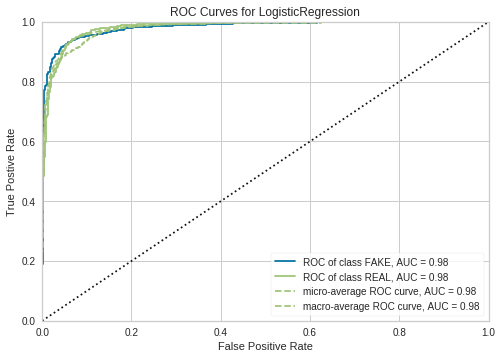

In [0]:
from sklearn.linear_model import LogisticRegression

draw_RocAuc(LogisticRegression())

### 3.2.1 Simple Classifers

#### LogisticRegression

In [0]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression
clfLR = LogisticRegression()
clfLR = clfLR.fit(X_train, y_train)

y_pred = clfLR.predict(X_test)

# check the accuracy on the training set
clfLR.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9167862266857962

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


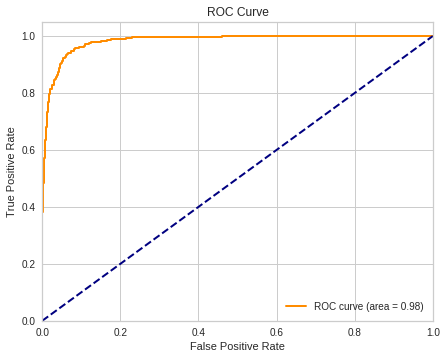

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.89      0.96      0.92      1071
        Fake       0.95      0.87      0.91      1020

    accuracy                           0.92      2091
   macro avg       0.92      0.92      0.92      2091
weighted avg       0.92      0.92      0.92      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


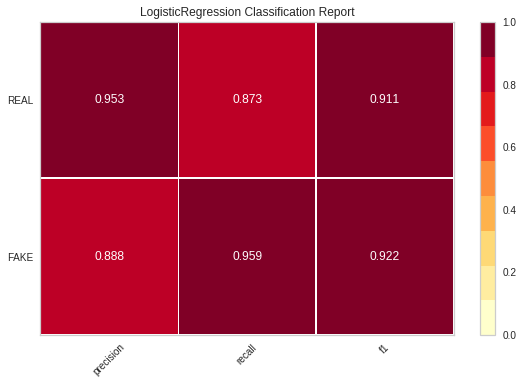

In [0]:
from sklearn.metrics import classification_report

draw_ROC(clfLR)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(clfLR)

#### RandomForest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# RandomForestClassifier
clfRF = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clfRF.fit(X_train, y_train) 
ansRF = clfRF.predict(X_test) 

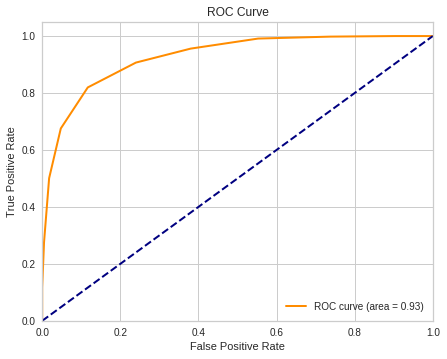

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.84      0.88      0.86      1071
        Fake       0.87      0.82      0.84      1020

    accuracy                           0.85      2091
   macro avg       0.85      0.85      0.85      2091
weighted avg       0.85      0.85      0.85      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


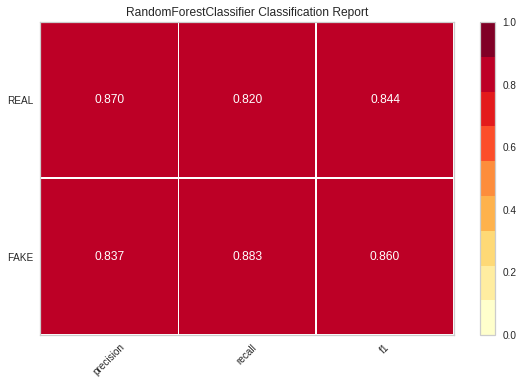

In [0]:
from sklearn.metrics import classification_report

draw_ROC(clfRF)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, ansRF, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(clfRF)

#### XGB

In [0]:
from xgboost import XGBClassifier

XGmodel = XGBClassifier(max_depth=7, learning_rate=0.2, 
                        n_estimators=100, silent=True, 
                        objective='binary:logistic', nthread=-1, 
                        gamma=0, min_child_weight=1, max_delta_step=0, 
                        subsample=1, colsample_bytree=1, 
                        colsample_bylevel=1, reg_alpha=0, 
                        reg_lambda=1, scale_pos_weight=1, 
                        base_score=0.5, seed=0, missing=None)

XGmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=1, verbosity=1)

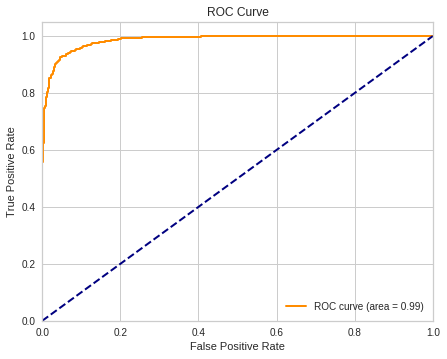

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.89      0.96      0.92      1071
        Fake       0.95      0.87      0.91      1020

    accuracy                           0.92      2091
   macro avg       0.92      0.92      0.92      2091
weighted avg       0.92      0.92      0.92      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


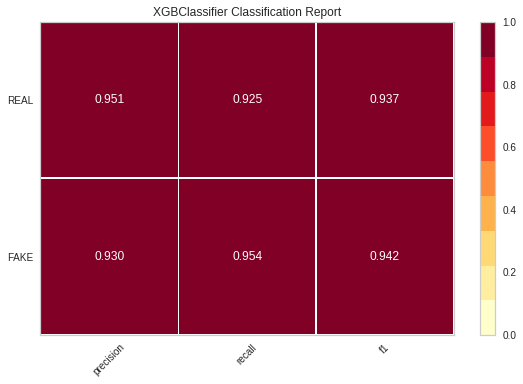

In [0]:
from sklearn.metrics import classification_report

draw_ROC(XGmodel)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(XGmodel)

## 3.3 Hypertuning - finding the optimal set of hyperparameters
Try the model we used in the simple way, and use Random & Grid SearchCV algorism to find better parameters 

### 3.3.1 Randomized SearchCV

##### Logic Regression

In [0]:
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [0]:
from sklearn.linear_model import LogisticRegression

clfLR = LogisticRegression()

In [0]:
param_dist = {
'penalty': ('l1', 'l2'),
'C': (0.01, 0.1, 1, 10),
}
 
# number of models we are going to train
n_iter_search = 20

# create our randomized gridsearch classifier
random_search = RandomizedSearchCV(clfLR,param_distributions=param_dist,n_jobs=4,
                                   n_iter=n_iter_search, return_train_score=True)

# start a timer so we know how long the random gridsearch took
start = time()
# perform the random gridsearch
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." 
      % ((time() - start), n_iter_search))

# print the top 3 model outputs from the random gridsearch
report(random_search.cv_results_)
random_search.best_params_, random_search.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomizedSearchCV took 11.55 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.931 (std: 0.011)
Parameters: {'penalty': 'l2', 'C': 10}

Model with rank: 2
Mean validation score: 0.925 (std: 0.002)
Parameters: {'penalty': 'l1', 'C': 10}

Model with rank: 3
Mean validation score: 0.913 (std: 0.008)
Parameters: {'penalty': 'l2', 'C': 1}



({'C': 10, 'penalty': 'l2'}, 0.9311969839773798)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


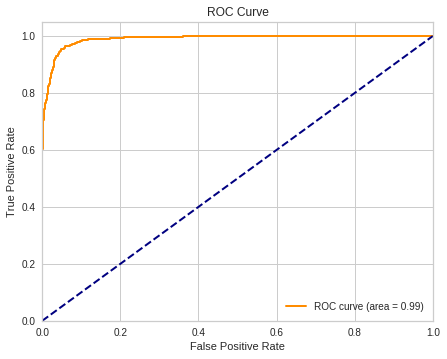

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.93      0.96      0.95      1071
        Fake       0.96      0.93      0.94      1020

    accuracy                           0.95      2091
   macro avg       0.95      0.95      0.95      2091
weighted avg       0.95      0.95      0.95      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


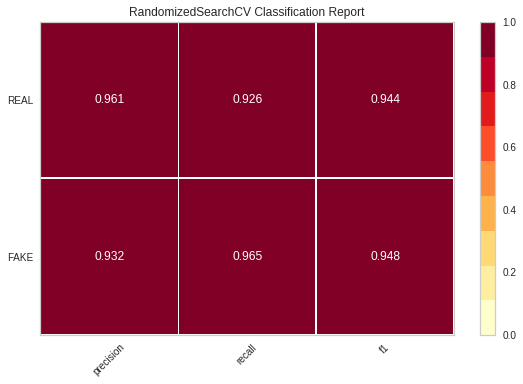

In [0]:
from sklearn.metrics import classification_report

draw_ROC(random_search)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(random_search)

##### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

clfRF = RandomForestClassifier(n_estimators=20)

In [0]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# specify parameters and distributions
param_dist = {"n_estimators": [10, 15, 20],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf": [2, 4, 6],}

# number of models we are going to train
n_iter_search = 100
# create our randomized gridsearch classifier
random_search = RandomizedSearchCV(clfRF, param_distributions=param_dist,n_jobs=4,
                                   n_iter=n_iter_search, return_train_score=True)
# start a timer so we know how long the random gridsearch took
start = time()
# perform the random gridsearch
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." 
      % ((time() - start), n_iter_search))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV took 57.64 seconds for 100 candidates parameter settings.


In [0]:
# print the top 3 model outputs from the random gridsearch
report(random_search.cv_results_)
random_search.best_params_, random_search.best_score_

Model with rank: 1
Mean validation score: 0.834 (std: 0.008)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 8}

Model with rank: 2
Mean validation score: 0.832 (std: 0.011)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.825 (std: 0.013)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}



({'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 2,
  'min_samples_leaf': 1,
  'min_samples_split': 8},
 0.8336475023562677)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


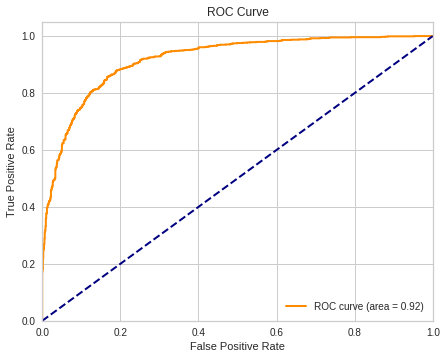

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.85      0.83      0.84      1071
        Fake       0.82      0.85      0.84      1020

    accuracy                           0.84      2091
   macro avg       0.84      0.84      0.84      2091
weighted avg       0.84      0.84      0.84      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


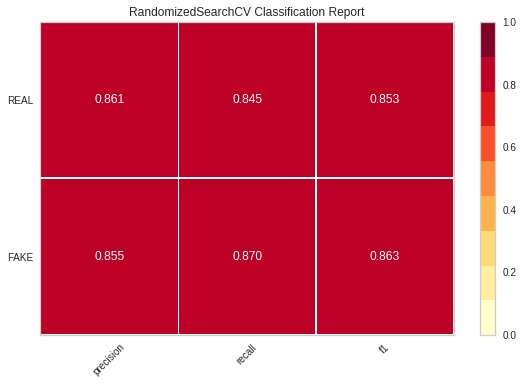

In [0]:
from sklearn.metrics import classification_report

draw_ROC(random_search)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(random_search)

##### XGBClassifier

In [0]:
from xgboost import XGBClassifier

clfXGB = XGBClassifier()

In [0]:
# specify parameters and distributions
param_dist = {
        'n_estimators':range(80,200,4),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,2,20),
        'subsample':np.linspace(0.7,0.9,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,9,1)
        }

# number of models we are going to train
n_iter_search = 20

# create our randomized gridsearch classifier
random_search = RandomizedSearchCV(clfXGB,param_distributions=param_dist,n_jobs=4,
                                   n_iter=n_iter_search, return_train_score=True)

# start a timer so we know how long the random gridsearch took
start = time()
# perform the random gridsearch
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." 
      % ((time() - start), n_iter_search))

# print the top 3 model outputs from the random gridsearch
report(random_search.cv_results_)
random_search.best_params_, random_search.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV took 1181.44 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.924 (std: 0.004)
Parameters: {'subsample': 0.8473684210526315, 'n_estimators': 144, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.21947368421052632, 'colsample_bytree': 0.8733333333333333}

Model with rank: 2
Mean validation score: 0.921 (std: 0.007)
Parameters: {'subsample': 0.7526315789473684, 'n_estimators': 104, 'min_child_weight': 7, 'max_depth': 11, 'learning_rate': 0.21947368421052632, 'colsample_bytree': 0.8733333333333333}

Model with rank: 3
Mean validation score: 0.916 (std: 0.004)
Parameters: {'subsample': 0.7947368421052632, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.638421052631579, 'colsample_bytree': 0.7666666666666666}



({'colsample_bytree': 0.8733333333333333,
  'learning_rate': 0.21947368421052632,
  'max_depth': 10,
  'min_child_weight': 5,
  'n_estimators': 144,
  'subsample': 0.8473684210526315},
 0.9238925541941565)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


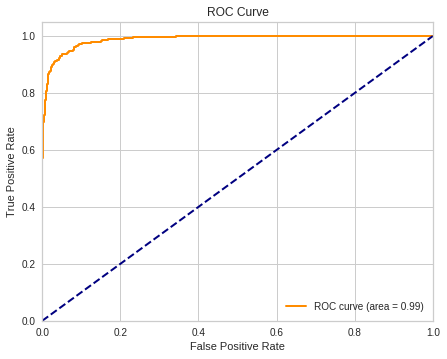

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.94      0.95      0.95      1071
        Fake       0.95      0.94      0.94      1020

    accuracy                           0.94      2091
   macro avg       0.94      0.94      0.94      2091
weighted avg       0.94      0.94      0.94      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


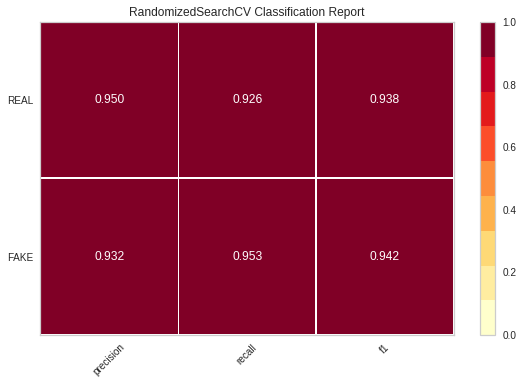

In [0]:
from sklearn.metrics import classification_report

draw_ROC(random_search)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(random_search)

### 3.3.2 Exhaustive Grid SearchCV

In [0]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


##### Logic Regression

In [0]:
# use a full grid over all parameters. 
param_grid = {'penalty': ('l1', 'l2'),'C': (0.01, 0.1, 1, 10)}

# create an exhaustive gridsearch object
grid_search = GridSearchCV(clfLR, param_grid = param_grid, return_train_score=True)

# start a timer so we know how long the exhaustive gridsearch took
start = time()

# perform the exhaustive gridsearch
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_)))

# print the top 3 model outputs from the exhaustive gridsearch
report(grid_search.cv_results_)
grid_search.best_params_, grid_search.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV took 6.65 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.931 (std: 0.011)
Parameters: {'C': 10, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.925 (std: 0.002)
Parameters: {'C': 10, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.913 (std: 0.008)
Parameters: {'C': 1, 'penalty': 'l2'}



({'C': 10, 'penalty': 'l2'}, 0.9311969839773798)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


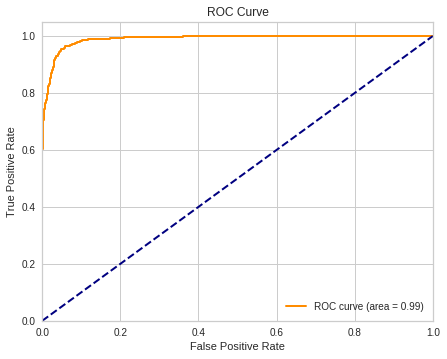

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.93      0.96      0.95      1071
        Fake       0.96      0.93      0.94      1020

    accuracy                           0.95      2091
   macro avg       0.95      0.95      0.95      2091
weighted avg       0.95      0.95      0.95      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


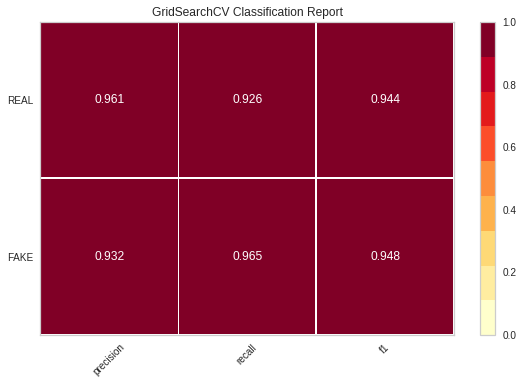

In [0]:
from sklearn.metrics import classification_report

draw_ROC(grid_search)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(grid_search)

#####  Random Forest

In [0]:
# use a full grid over all parameters. 
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2,3,10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# create an exhaustive gridsearch object
grid_search = GridSearchCV(clfRF, param_grid=param_grid, return_train_score=True)

# start a timer so we know how long the exhaustive gridsearch took
start = time()

# perform the exhaustive gridsearch
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_)))

# print the top 3 model outputs from the exhaustive gridsearch
report(grid_search.cv_results_)
grid_search.best_params_, grid_search.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV took 292.84 seconds for 22 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.841 (std: 0.005)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.838 (std: 0.011)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.838 (std: 0.010)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}



({'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 10},
 0.8411875589066918)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


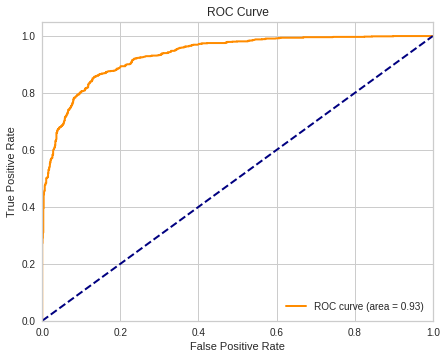

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        True       0.86      0.85      0.85      1071
        Fake       0.84      0.85      0.85      1020

    accuracy                           0.85      2091
   macro avg       0.85      0.85      0.85      2091
weighted avg       0.85      0.85      0.85      2091

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


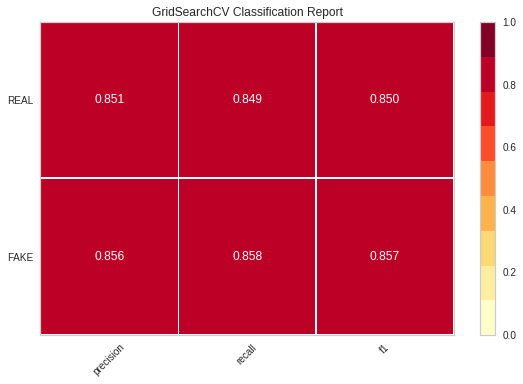

In [0]:
from sklearn.metrics import classification_report

draw_ROC(grid_search)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(grid_search)

##### XGBClassifier

In [0]:
# use a full grid over all parameters. 
param_grid = {
        'n_estimators':range(80,200,4),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,2,20),
        'subsample':np.linspace(0.7,0.9,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,9,1)
        }

# create an exhaustive gridsearch object
grid_search = GridSearchCV(clfXGB, param_grid=param_grid, return_train_score=True)

# start a timer so we know how long the exhaustive gridsearch took
start = time()

# perform the exhaustive gridsearch
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_)))

# print the top 3 model outputs from the exhaustive gridsearch
report(grid_search.cv_results_)
grid_search.best_params_, grid_search.best_score_

In [0]:
from sklearn.metrics import classification_report

draw_ROC(grid_search)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
draw_tgraph(grid_search)

## 3.4 Keras

### 3.4.1 Split the dataset

In [0]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, label_binary[:], test_size=0.33, random_state=42)
line,dim = tfidf_matrix.shape

### 3.4.2 Build the Keras model

In [0]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model(optimizer='Nadam'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=dim, activation='relu')) #Alleviates gradient dissipation and speeds up the convergence rate.
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

X=tfidf_matrix[:,:]
y=label[:]

model = KerasClassifier(build_fn=create_model, nb_epoch=100, batch_size=10,verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

Using TensorFlow backend.


### 3.4.3 Find the best optimiser

In [0]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train_new,y_train_new,validation_data=(X_test_new, y_test_new))
#grid_result = grid.fit(X_train_new, y_train_new,epochs=10,validation_data=(X_test_new, y_test_new),callbacks=[PlotLossesKeras()],verbose=0)

# summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
W0819 09:15:53.254337 140229740808064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 09:15:53.288544 140229740808064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder in

Best: 0.9276625754752326 using {'optimizer': 'Nadam'}
0.510603 (0.009338) with: {'optimizer': 'SGD'}
0.902922 (0.008680) with: {'optimizer': 'RMSprop'}
0.919887 (0.007679) with: {'optimizer': 'Adagrad'}
0.892790 (0.017327) with: {'optimizer': 'Adadelta'}
0.923186 (0.009556) with: {'optimizer': 'Adam'}
0.905042 (0.008194) with: {'optimizer': 'Adamax'}
0.927663 (0.011560) with: {'optimizer': 'Nadam'}


### 3.4.4 Using best one and report

In [0]:
history = model.fit(
    X_train,y_train, 
    epochs=20, batch_size=512, 
    validation_data=(X_test_new,y_test_new))

In [0]:
print(history.history)

{'val_loss': [0.6348068202471174, 0.5780728725027889, 0.5223747573646844, 0.4725192374786311, 0.4264548448556237, 0.38792015188108614, 0.3551195290942673, 0.3273496503809432, 0.3040202278688386, 0.2851089573915583, 0.2680804754688887, 0.2544224927979528, 0.2423249158432813, 0.23219959586787486, 0.2229900164774649, 0.21558868218728197, 0.2087528477839338, 0.202666980421526, 0.19747873577759176, 0.19275926064213517], 'val_acc': [0.8751793394300825, 0.9033955045432808, 0.9163079863812352, 0.9105691052349716, 0.9273075081411587, 0.9292204684472324, 0.9296987085237508, 0.9320899089063428, 0.9344811092889349, 0.9354375894419718, 0.9363940693669659, 0.9387852699776006, 0.9397417499025947, 0.9397417499025947, 0.9397417499025947, 0.9411764703601927, 0.9416547104367111, 0.9426111905897478, 0.9435676707427847, 0.9435676707427847], 'loss': [0.6677918253250553, 0.5958408954905295, 0.5202990252661548, 0.4480860801826211, 0.38298326303776875, 0.3263393098683317, 0.27826199348415553, 0.237879788392450

Loss and Accuracy

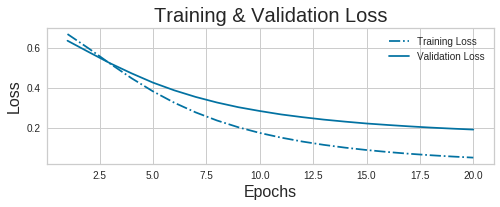

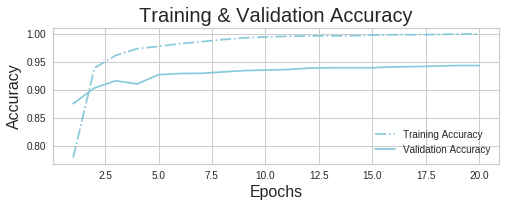

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']   # Train dataset loss
val_loss_values = history_dict['val_loss']  # Test dataset loss
plt.subplot(211)
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b-.', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training & Validation Loss',fontsize=20)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, history_dict['acc'], 'c-.', label='Training Accuracy')
plt.plot(epochs, history_dict['val_acc'], 'c', label='Validation Accuracy')
plt.title('Training & Validation Accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
plt.show()

Real-time Showing

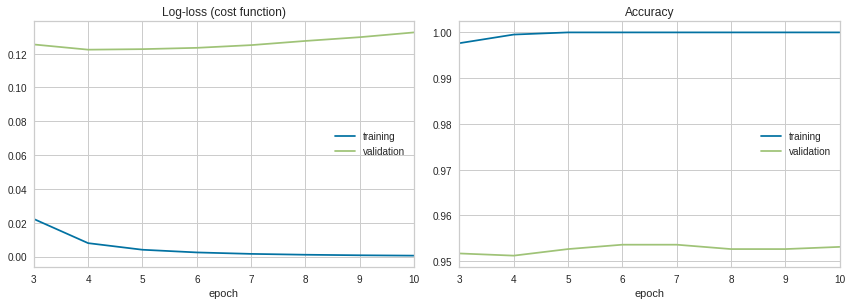

Log-loss (cost function):
training   (min:    0.001, max:    0.386, cur:    0.001)
validation (min:    0.122, max:    0.192, cur:    0.133)

Accuracy:
training   (min:    0.898, max:    1.000, cur:    1.000)
validation (min:    0.940, max:    0.954, cur:    0.953)


In [0]:
from livelossplot import PlotLossesKeras

model.fit(X_train_new, y_train_new,
          epochs=10,
          validation_data=(X_test_new, y_test_new),
          callbacks=[PlotLossesKeras()],
          verbose=0)

## 3.5 BERT

### 3.5.1 Load dataset

In [0]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
datasetPath = "/content/drive/My Drive/Colab Notebooks/data/fake_or_real_news.csv"

df = pd.read_csv(datasetPath)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 3.5.2 Change label to 1/0

In [0]:
df['label'].loc[df['label'] == 'REAL'] = '1'
df['label'].loc[df['label'] == 'FAKE'] = '0'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 3.5.3 Generate the train and test dataset

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.33, random_state=42)

train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from bert_text import run_on_dfs

W0820 09:17:27.829614 139710227371904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0820 09:17:27.832411 139710227371904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert_text/bert_text.py:10: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0820 09:17:27.833328 139710227371904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert_text/bert_text.py:10: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



### 3.5.4 Set the parameter

In [0]:
myparam = {
    "DATA_COLUMN": "text",
    "LABEL_COLUMN": "label",
    "LEARNING_RATE": 2e-5,
    "NUM_TRAIN_EPOCHS": 5
}

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

### 3.5.5 Run the BERT

In [0]:
result, estimator = run_on_dfs(train,test, **myparam)

I0820 09:39:17.293086 139710227371904 saver.py:1499] Saver not created because there are no variables in the graph to restore
I0820 09:39:17.910086 139710227371904 run_classifier.py:774] Writing example 0 of 4244
I0820 09:39:17.919245 139710227371904 run_classifier.py:461] *** Example ***
I0820 09:39:17.923353 139710227371904 run_classifier.py:462] guid: None
I0820 09:39:17.925320 139710227371904 run_classifier.py:464] tokens: [CLS] the next president is most likely to face an international crisis shortly after taking office — and both donald trump and hillary clinton " have a credibility problem in foreign affairs , " former defense secretary robert gates said friday . " clinton was the senior - most advocate for using the u . s . military to bring ill - fated regime change in libya and , further , failed to anti ##ci ##pate the chaos that would follow , " gates , who has served eight presidents over 50 years , wrote in an op - ed in the wall street journal . " the same failure she an

### 3.5.6 Show the result

In [0]:
result

{'auc': 0.9682539,
 'eval_accuracy': 0.9679579,
 'f1_score': 0.9683215,
 'false_negatives': 47.0,
 'false_positives': 20.0,
 'global_step': 397,
 'loss': 0.13262913,
 'precision': 0.9808429,
 'recall': 0.9561158,
 'true_negatives': 1000.0,
 'true_positives': 1024.0}

# 4. PengMeng

## 4.1 Simple Classifier

In [0]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp
from sklearn.model_selection import cross_val_score

### 4.1.1 KNN

In [0]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

target_names = ['True', 'Fake']
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))
clf.score(X_test, y_test)

In [0]:
clf.fit(x0_train, y0_train)

print(classification_report(y0_test, clf.predict(x0_test), target_names=target_names))
clf.score(x0_test, y0_test)

              precision    recall  f1-score   support

        True       0.89      0.82      0.85      1039
        Fake       0.83      0.90      0.87      1052

    accuracy                           0.86      2091
   macro avg       0.86      0.86      0.86      2091
weighted avg       0.86      0.86      0.86      2091



0.8598756575801052

### 4.1.2 Naive Bayes

In [0]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test), target_names=target_names))
clf.score(X_test, y_test)

              precision    recall  f1-score   support

        True       0.81      0.89      0.85      1071
        Fake       0.87      0.78      0.82      1020

    accuracy                           0.83      2091
   macro avg       0.84      0.83      0.83      2091
weighted avg       0.84      0.83      0.83      2091



0.8335724533715926

In [0]:
clf.fit(x0_train, y0_train)

print(classification_report(y0_test, clf.predict(x0_test), target_names=target_names))
clf.score(x0_test, y0_test)

              precision    recall  f1-score   support

        True       0.76      0.85      0.80      1039
        Fake       0.83      0.73      0.78      1052

    accuracy                           0.79      2091
   macro avg       0.79      0.79      0.79      2091
weighted avg       0.79      0.79      0.79      2091



0.790052606408417

### 4.1.3 SVM

In [0]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

target_names = ['True', 'Fake']
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))
clf.score(X_test, y_test)

              precision    recall  f1-score   support

        True       0.93      0.96      0.95      1071
        Fake       0.96      0.93      0.94      1020

    accuracy                           0.94      2091
   macro avg       0.94      0.94      0.94      2091
weighted avg       0.94      0.94      0.94      2091



0.9435676709708274

In [0]:
clf.fit(x0_train, y0_train)

print(classification_report(y0_test, clf.predict(x0_test), target_names=target_names))
clf.score(x0_test, y0_test)

              precision    recall  f1-score   support

        True       0.89      0.90      0.90      1039
        Fake       0.90      0.89      0.90      1052

    accuracy                           0.90      2091
   macro avg       0.90      0.90      0.90      2091
weighted avg       0.90      0.90      0.90      2091



0.896700143472023

In [0]:
score = cross_val_score(clf, X_train, y_train, cv=5).mean()
print(score)

0.9401581850554743


## 4.2 Hypertunning -- Base on Hyperopt

In [0]:
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, partial, Trials, STATUS_OK

In [0]:
# tf-idf
X=tfidf_matrix[:,:]
y=df.label[:]

df['label'].loc[df['label'] == '1'] = 1
df['label'].loc[df['label'] == '0'] = 0

X_f1=tfidf_matrix[:,:]
y_f1=df.label[:]
X_train_f1, X_test_f1, y_train_f1, y_test_f1 = train_test_split(X_f1, y_f1, test_size=0.33, random_state=42)

### 4.2.1 Random forest

**(1) TF-IDF**

In [0]:
from sklearn.ensemble import RandomForestClassifier
def RF(argsDict):
    max_depth = argsDict["max_depth"] + 5
    n_estimators = argsDict['n_estimators'] * 5 + 50
    
    clfRF = RandomForestClassifier(max_depth=max_depth,
                                n_estimators=n_estimators)

    metric = cross_val_score(clfRF,X_train,y_train,cv=10,scoring="roc_auc").mean()
    return -metric

space = {"max_depth":hp.choice("max_depth",[40,50]),
         "n_estimators":hp.randint("n_estimators",50),   
         "criterion":hp.choice("criterion", ['gini', 'entropy'])
        }
algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(RF,space,algo=algo,max_evals=10)
print(best)

100%|██████████| 10/10 [17:59<00:00, 113.43s/it, best loss: -0.970928156906635]
{'criterion': 1, 'max_depth': 1, 'n_estimators': 49}


In [0]:
paraRF = {'criterion': 'entropy', 'max_depth': 55, 'n_estimators': 295}

clfRF = RandomForestClassifier()
clfRF.set_params(**paraRF)

In [0]:
clfRF.fit(X_train, y_train)
y_pred = clfRF.predict(X_test)

target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred, target_names=target_names))
clfRF.score(X_test, y_test)

              precision    recall  f1-score   support

        True       0.91      0.93      0.92      1071
        Fake       0.93      0.90      0.91      1020

    accuracy                           0.92      2091
   macro avg       0.92      0.92      0.92      2091
weighted avg       0.92      0.92      0.92      2091



0.9158297465327594

**(2) FastText**

**FastText-cross_val-AUC**

In [0]:
from sklearn.ensemble import RandomForestClassifier


def RF(argsDict):
    max_depth = argsDict["max_depth"] + 5
    n_estimators = argsDict['n_estimators'] * 5 + 50
    
    clf = RandomForestClassifier(max_depth=max_depth,
                                n_estimators=n_estimators)

    metric = cross_val_score(clf,x0_train, y0_train,cv=10,scoring="roc_auc").mean()
    return -metric

space = {"max_depth":hp.choice("max_depth",[40,50]),
         "n_estimators":hp.randint("n_estimators",50),   
         "criterion":hp.choice("criterion", ['gini', 'entropy'])
        }
algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(RF,space,algo=algo,max_evals=10)
print(best)

100%|██████████| 10/10 [15:29<00:00, 125.05s/it, best loss: -0.9644278569527357]
{'criterion': 1, 'max_depth': 0, 'n_estimators': 38}


In [0]:
paraRF_ft = {'criterion': 'gini', 'max_depth': 45, 'n_estimators': 240}

clfRF_ft = RandomForestClassifier()
clfRF_ft.set_params(**paraRF_ft)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=45, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=240,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
clfRF_ft.fit(x0_train, y0_train)
y_pred_ft = clfRF_ft.predict(x0_test)

target_names = ['True', 'Fake']
print(classification_report(y0_test, y_pred_ft, target_names=target_names))
clfRF_ft.score(x0_test, y0_test)

              precision    recall  f1-score   support

        True       0.88      0.90      0.89      1039
        Fake       0.90      0.88      0.89      1052

    accuracy                           0.89      2091
   macro avg       0.89      0.89      0.89      2091
weighted avg       0.89      0.89      0.89      2091



0.8890483022477284

**TF-IDF-cross_val_f1**

In [0]:
from sklearn.ensemble import RandomForestClassifier

def RF(argsDict):
    max_depth = argsDict["max_depth"] + 5
    n_estimators = argsDict['n_estimators'] * 5 + 50
    
    clf = RandomForestClassifier(max_depth=max_depth,
                                n_estimators=n_estimators)

    metric = cross_val_score(clf,X_train_f1, y_train_f1,cv=10,scoring="f1").mean()
    return -metric

space = {"max_depth":hp.choice("max_depth",[40,50]),
         "n_estimators":hp.randint("n_estimators",50),   
         "criterion":hp.choice("criterion", ['gini', 'entropy'])
        }
algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(RF,space,algo=algo,max_evals=10)
print(best)

100%|██████████| 10/10 [25:11<00:00, 122.24s/it, best loss: -0.9190062159133184]
{'criterion': 1, 'max_depth': 1, 'n_estimators': 33}


In [0]:
paraRF_f1 = {'criterion': 'entropy', 'max_depth': 46, 'n_estimators': 215}

clfRF_f1 = RandomForestClassifier()
clfRF_f1.set_params(**paraRF_f1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=46, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=215,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
clfRF_f1.fit(x0_train, y0_train)
y_pred_f1 = clfRF_f1.predict(x0_test)

target_names = ['True', 'Fake']
print(classification_report(y0_test, y_pred_f1, target_names=target_names))
clfRF.score(x0_test, y0_test)


              precision    recall  f1-score   support

        True       0.88      0.93      0.91      1039
        Fake       0.93      0.88      0.90      1052

    accuracy                           0.90      2091
   macro avg       0.90      0.90      0.90      2091
weighted avg       0.91      0.90      0.90      2091



0.9655667144906743

### 4.2.2 XGBoost

In [0]:
from xgboost import XGBClassifier
def XGB(argsDict):
    max_depth = argsDict["max_depth"]
    n_estimators = argsDict["n_estimators"]
    learning_rate = argsDict["learning_rate"] * 0.002
    subsample = argsDict["subsample"] * 0.1 + 0.6
    
    xgb = XGBClassifier(nthread=4,    
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        max_delta_step = 10,
                        objective="binary:logistic")

    metric = cross_val_score(xgb,X_train,y_train,cv=10,scoring="roc_auc").mean()
    return -metric

space = {"max_depth":hp.randint("max_depth",15),
         "n_estimators":hp.choice("n_estimators",[10, 100, 200]),  
         "learning_rate":hp.randint("learning_rate",10),  
         "subsample":hp.randint("subsample",4),
        }
algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(XGB,space,algo=algo,max_evals=10)
print(best)

100%|██████████| 10/10 [2:01:34<00:00, 613.01s/it, best loss: -0.9726149569562462]
{'learning_rate': 8, 'max_depth': 12, 'n_estimators': 2, 'subsample': 3}


In [0]:
paraXGB = {'learning_rate': 0.016, 'max_depth': 12, 'n_estimators': 200, 'subsample': 0.9}

clfXGB = XGBClassifier()
clfXGB.set_params(**paraXGB)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.016, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [0]:
clfXGB.fit(X_train, y_train)
y_pred_XGB = clfXGB.predict(X_test)

target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred_XGB, target_names=target_names))
clfXGB.score(X_test, y_test)


              precision    recall  f1-score   support

        True       0.90      0.92      0.91      1071
        Fake       0.92      0.89      0.91      1020

    accuracy                           0.91      2091
   macro avg       0.91      0.91      0.91      2091
weighted avg       0.91      0.91      0.91      2091



0.9086561453849833

### 4.2.3 KNN

**TF-IDF**

In [0]:
from sklearn.neighbors import KNeighborsClassifier 
from hyperopt import fmin, tpe, hp

def KNN(params):
    clf = KNeighborsClassifier(**params)
    acc = cross_val_score(clf, X_train, y_train, cv=10,scoring="roc_auc").mean()
    return -acc

spaceknn = {
    'n_neighbors': hp.choice('n_neighbors', range(120,200))
}

algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(KNN, spaceknn, algo=algo, max_evals=10)
print(best)

In [0]:
paraKNN = {'n_neighbors':125}

clfKNN = KNeighborsClassifier()
clfKNN.set_params(**paraKNN)
clfKNN.fit(X_train, y_train)
y_pred_KNN = clfKNN.predict(X_test)

target_names = ['True', 'Fake']
print(classification_report(y_test, y_pred_KNN, target_names=target_names))
clfKNN.score(X_test, y_test)


              precision    recall  f1-score   support

        True       0.90      0.78      0.83      1071
        Fake       0.80      0.91      0.85      1020

    accuracy                           0.84      2091
   macro avg       0.85      0.84      0.84      2091
weighted avg       0.85      0.84      0.84      2091



0.8417025346724055

**TF-IDF -cross_val-f1**

In [0]:
from sklearn.neighbors import KNeighborsClassifier 
from hyperopt import fmin, tpe, hp

def KNN(params):
    clf = KNeighborsClassifier(**params)
    acc = cross_val_score(clf, X_train_f1, y_train_f1, cv=10,scoring="f1").mean()
    return -acc

spaceknn = {
    'n_neighbors': hp.choice('n_neighbors', range(65,100))
}

algo = partial(tpe.suggest,n_startup_jobs=1)
best = fmin(KNN, spaceknn, algo=algo, max_evals=10)
print(best)

In [0]:
paraKNN_f1 = {'n_neighbors':74}

clfKNN_f1 = KNeighborsClassifier()
clfKNN_f1.set_params(**paraKNN_f1)
clfKNN_f1.fit(X_train_f1, y_train_f1)
y_pred_KNN = clfKNN_f1.predict(X_test_f1)

target_names = ['True', 'Fake']
print(classification_report(y_test_f1, y_pred_KNN, target_names=target_names))
clfKNN_f1.score(X_test_f1, y_test_f1)

              precision    recall  f1-score   support

        True       0.89      0.81      0.85      1020
        Fake       0.84      0.91      0.87      1071

    accuracy                           0.86      2091
   macro avg       0.87      0.86      0.86      2091
weighted avg       0.86      0.86      0.86      2091



0.8622668579626973

### 4.2.4 Tunning 

In [0]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [0]:
def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    elif t == 'randomforest':
        clf = RandomForestClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, X_train, y_train, cv=5).mean()

space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,5)),
        'n_estimators': hp.choice('n_estimators', range(1,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print('new best:', acc, 'using', params['type'])
        best = acc
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print(best)

new best:
0.8199881632631717
using
naive_bayes
new best:
0.9337935953900194
using
svm
new best:
0.9347364360238395
using
svm
new best:
0.937093538262028
using
svm
new best:
0.9387428155341075
using
svm
new best:
0.9389783867944137
using
svm
new best:
0.9401565208922426
using
svm
new best:
0.9425130662305591
using
svm
new best:
0.9432206134003704
using
svm
100%|██████████| 100/100 [2:07:01<00:00, 113.40s/it, best loss: -0.9432206134003704]
best:
{'C': 1.4046867226952349, 'classifier_type': 1, 'gamma': 12.6501602210115, 'kernel': 0}


In [0]:
params_svc = {'C': 1.4046867226952349, 'gamma': 12.6501602210115, 'kernel': 'linear'}
clfSVM = SVC()
clfSVM.set_params(**params_svc)
clfSVM.fit(X_train, y_train)
target_names = ['True', 'Fake']
print(classification_report(y_test, clfSVM.predict(X_test), target_names = target_names))
print(accuracy_score(y_test, clfSVM.predict(X_test)))

              precision    recall  f1-score   support

        True       0.94      0.96      0.95      1071
        Fake       0.96      0.93      0.94      1020

    accuracy                           0.95      2091
   macro avg       0.95      0.95      0.95      2091
weighted avg       0.95      0.95      0.95      2091

0.9844666890639953


## 4.3 Pipeline
A micro model of whole processes

In [0]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(joined_cleanedText, converted_label, test_size=0.33, random_state=42)

### 4.3.1 tSVD 

In [0]:
# Linear dimensionality reduction using truncated singular value decomposition (SVD)
# In the context of working on term count/tf-idf matrices as returned vectorizers, AKA latent semantic analysis (LSA)
# Works with scipy.sparse matrices efficiently
tSVD = TruncatedSVD()

In [0]:
# This step that simply prints shape of data. Does not actually fit to or transform data.
class printshape(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [0]:
# Create a spaCy pipeline for processing data. 
# 1: create tf-idf vectors; 2: dimensionality reduction; 3: classify using Extra Trees
pipe = Pipeline([('vectorizer', vectorizer), 
                 ('printsh', printshape()),
                 ('tSVD', tSVD),
                 ('printsh2', printshape()),
                 ('clf', XGBClassifier())
                ])
pipe.get_params()

Param space

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Build hyperparameter grid for RandomizedSearchCV
# Randomly pick combinations of parameters to try for Truncated SVD and XGBClassifier

param_grid = {
    # n_components = desired dimensionality of output data
    # n_iter = number of iterations for randomized SVD solver. default = 5
    'tSVD__n_components': [50, 150, 250,300, 400],
    'tSVD__n_iter': [5, 7, 10],
    
    # n_estimators = number of trees in the forest
    # max_depth = max number of levels in each decision tree
    
    'clf__n_estimators':range(80,200,4),
    'clf__max_depth':range(2,15,1),
    'clf__learning_rate':np.linspace(0.01,1,20),
    'clf__subsample':np.linspace(0.7,0.9,20),
    'clf__colsample_bytree':np.linspace(0.5,0.98,10),
    'clf__min_child_weight':range(1,9,1)

}

# cv = 5 (5-fold cross-validation)
# n_jobs = -1 (uses all available cores/processors)
search = RandomizedSearchCV(estimator=pipe, 
                            param_distributions=param_grid, 
                            n_iter=10, 
                            n_jobs=-1, 
                            cv=5,
                            verbose=3, 
                            random_state=42)

In [0]:
search.fit(X_train, y_train)

In [0]:
# Print classification accuracy score, precision ...
target_names = ['True', 'Fake']
y_pred= search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
print("accuracy:", accuracy_score(y_test, y_pred))

(2091, 56795)
(2091, 400)
              precision    recall  f1-score   support

        True       0.93      0.90      0.91      1071
        Fake       0.90      0.92      0.91      1020

    accuracy                           0.91      2091
   macro avg       0.91      0.91      0.91      2091
weighted avg       0.91      0.91      0.91      2091

accuracy: 0.9124820659971306


In [0]:
# Create a spaCy pipeline for processing data. 
# 1: create tf-idf vectors; 2: dimensionality reduction; 3: classify using SVC
pipe = Pipeline([('vectorizer', vectorizer), 
                 ('printsh', printshape()),
                 ('tSVD', tSVD),
                 ('printsh2', printshape()),
                 ('clf', SVC())
                ])
pipe.get_params()

Param space

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Build hyperparameter grid for RandomizedSearchCV
# Randomly pick combinations of parameters to try for Truncated SVD and SVC

param_grid = {
    # n_components = desired dimensionality of output data
    # n_iter = number of iterations for randomized SVD solver. default = 5
    'tSVD__n_components': [50, 150, 250, 300, 400],
    'tSVD__n_iter': [5, 7, 10],
    
    'clf__C': np.linspace(1,2,30),
    'clf__kernel': ['linear'],
    'clf__gamma': np.linspace(10,14,40)
}

# cv = 5 (5-fold cross-validation)
# n_jobs = -1 (uses all available cores/processors)
search = RandomizedSearchCV(estimator=pipe, 
                            param_distributions=param_grid, 
                            n_iter=10, 
                            n_jobs=-1, 
                            cv=5,
                            verbose=3, 
                            random_state=42)
search.fit(X_train, y_train)

In [0]:
# Print classification accuracy score, precision ...
target_names = ['True', 'Fake']
y_pred= search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
print("accuracy:", accuracy_score(y_test, y_pred))

(2091, 56795)
(2091, 250)
              precision    recall  f1-score   support

        True       0.90      0.94      0.92      1071
        Fake       0.93      0.90      0.91      1020

    accuracy                           0.92      2091
   macro avg       0.92      0.92      0.92      2091
weighted avg       0.92      0.92      0.92      2091

accuracy: 0.9158297465327594


### 4.3.2 TF-IDF

In [0]:
# Create a  pipeline for processing data. 
# 1: create tf-idf vectors; 2: classify using XGB
pipe = Pipeline([ 
                 ('embedder', TfidfVectorizer()),
                 ('clf', XGBClassifier())
                ])
pipe.get_params()

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import hp
from scipy.stats import randint as sp_randint
# Build hyperparameter grid for RandomizedSearchCV
# Randomly pick combinations of parameters to try for XGBClassifier

size_space = {
    'clf__n_estimators':range(80,200,4),
    'clf__max_depth':range(2,15,1),
    'clf__learning_rate':np.linspace(0.01,1,20),
    'clf__subsample':np.linspace(0.7,0.9,20),
    'clf__colsample_bytree':np.linspace(0.5,0.98,10),
    'clf__min_child_weight':range(1,9,1)
}

# cv = 5 (3-fold cross-validation)
# n_jobs = -1 (uses all available cores/processors)
search = RandomizedSearchCV(estimator=pipe, 
                            param_distributions=size_space, 
                            iid=False,
                            refit=True,
                            n_iter=10, 
                            n_jobs=-1, 
                            cv=5,
                            verbose=1, 
                            random_state=42,
                            pre_dispatch=8)
search.fit(X_train, y_train)

In [0]:
print(classification_report(y_test, search.predict(X_test)))
print("accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1071
           1       0.91      0.93      0.92      1020

    accuracy                           0.92      2091
   macro avg       0.92      0.92      0.92      2091
weighted avg       0.92      0.92      0.92      2091

accuracy: 0.9158297465327594


In [0]:
# Create a  pipeline for processing data. 
# 1: create tf-idf vectors; 2: classify using SVC
pipe = Pipeline([ 
                 ('embedder', TfidfVectorizer()),
                 ('clf', SVC())
                ])

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Build hyperparameter grid for RandomizedSearchCV
# Randomly pick combinations of parameters to try for SVC

param_grid = {
    'clf__C': np.linspace(1,2,30),
    'clf__kernel': ['linear'],
    'clf__gamma': np.linspace(10,14,40)
}

# cv = 5 (5-fold cross-validation)
# n_jobs = -1 (uses all available cores/processors)
search = RandomizedSearchCV(estimator=pipe, 
                            param_distributions=param_grid, 
                            n_iter=10, 
                            n_jobs=-1, 
                            cv=5,
                            verbose=3, 
                            random_state=42)


search.fit(X_train, y_train)

In [0]:
print(classification_report(y_test, search.predict(X_test)))
print("accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1071
           1       0.95      0.92      0.93      1020

    accuracy                           0.94      2091
   macro avg       0.94      0.94      0.94      2091
weighted avg       0.94      0.94      0.94      2091

accuracy: 0.9158297465327594
